# Taking off the Training Weels: Re-Balancing the Citibike System

**Author: Mitchell Krieger**
***

## Modeling

These models attempt to predict how many bikes are availble at a given station at a given time. Starting by isolating a typical 2 week interval to see if models are able to capture both daily and weekly seasonality. June 17th - June 30th, 2018 was chosen for its good weather, lack of significant holidays, and consistency of data collection across all stations (no missing values). Yearly seasonality will be set aside for now.

**Importing Relevant Packages**

In [1]:
import requests
import warnings
import json
import sys, os 
import numpy as np
import datetime as dt
import pandas as pd
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
plt.style.use('seaborn')

from src.cleaning import *
from src.station import *
from src.evaluation import rmse_mae
from src.hidden_printing import Hidden_Printer
from src.evaluation import series_to_supervised, repeat_evaluate, summarize_scores
import pickle

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

### Check for stationarity

Before modeling can begin, we need to ensure that each time series is stationary. Using the Dickey-Fuller test, we'll test for stationarity and isolate stations that are not. In addition, data will be resampled hourly to prep for models that require it.

In [2]:
#load in data and transform to a resampled hourly time x station matrix in a dataframe
year_2018 = pickle.load(open('./data/pickle/historical.pickle','rb'))
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()
station_mat.columns = [str(col) for col in station_mat.columns]


#interpolate timeseries with small amounts of  missing values
station_mat = station_mat.interpolate()

#drop station colums that have large amount of missing data due to installation/discontinuation 
# or major malfunction in 2018
station_drop = list(station_mat.isna().sum().sort_values(ascending=False).head(45).index)
station_mat.drop(columns=station_drop,inplace=True)

station_mat.head()

,72,79,82,83,116,119,120,127,128,143,...,3478,3481,3486,3489,3490,3491,3492,3493,3494,3495
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,13.0,4.0,3.0,30.0,0.0,12.0,7.0,5.0,10.5,12.5,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 01:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 02:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,3.0,9.0,13.0,...,16.0,7.0,14.0,5.0,5.0,13.0,16.0,11.0,17.0,20.0
2018-01-01 03:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,...,16.0,6.5,14.0,5.0,5.0,13.0,16.0,11.5,17.0,20.0
2018-01-01 04:00:00,13.0,4.0,4.0,30.0,0.0,12.0,7.0,5.0,9.0,13.0,...,16.0,6.0,14.0,5.0,5.0,13.0,16.0,12.0,17.0,20.0


**Dickey-Fuller Test**

Here we will iterate over columns and store result of test in dataframe. A value of True means that the null hypothesis of the dickey fuller test as been rejected, implying stationarity. This doesn't garuantee stationarity but it gives us an idea of how many stations are extremely unstationary.

In [3]:
dickey_results = pd.Series()

with Hidden_Printer(): #supresses Dickey-Fuller function's print
    
    for col in station_mat.columns:
      dftest = dickey_fuller(station_mat[col])
      dickey_results[col] = dftest


dickey_results.value_counts()

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


True     656
False      8
dtype: int64

Only 8 stations failed the dickey fuller test. Taking a closer look at each one by plotting them:

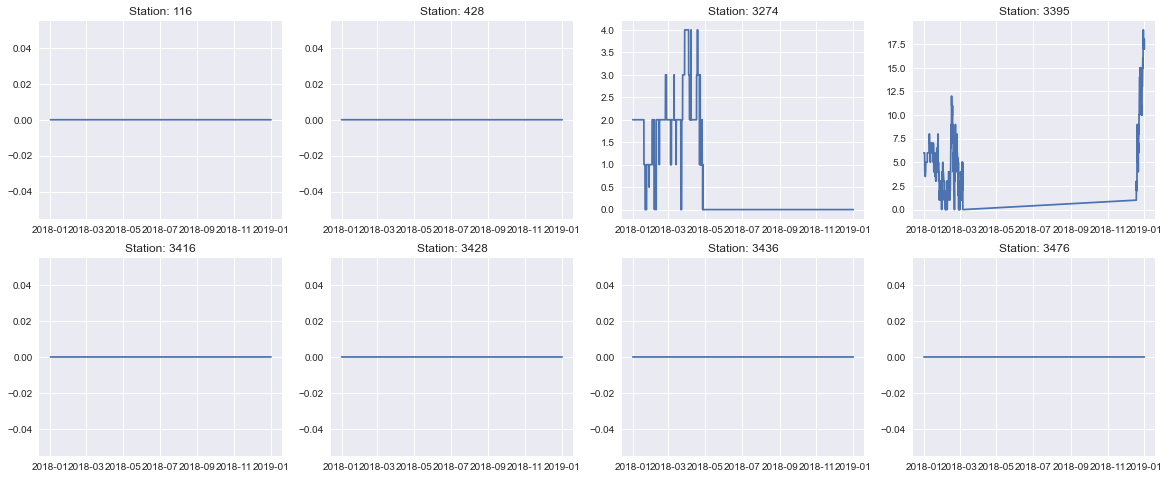

In [11]:
investigate = dickey_results.loc[dickey_results == False]

fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(20,8))

for i, ts in enumerate(investigate.index):
  ax[i//4][i%4].plot(station_mat[ts])
  ax[i//4][i%4].set_title(f'Station: {ts}')

It seems these fail the dickey-fuller test because they are actually stations that should have been dropped due to their lack of data. We'll remove them from out station matrix

In [12]:
station_mat.drop(columns=investigate.index,inplace=True)

### The Typical Station

For our inital models we'll use Station 3172 on the Upper West stide as our training data to examine the intricacies of station time series during our two week interval of June 17th - June 30th, 2018.

In [3]:
station_3172 = Station(3172)
station_3172.info()


        #### Station 3172 Info ####
        
        Name: W 74 St & Columbus Ave
        Status: active
        Legacy ID: 3172
        Type: classic
        Region: NYC District 
        Coordinates: (40.7785669,-73.97754961)
        Rental Methods: ['CREDITCARD', 'KEY']
        Has Kiosk: True
        
        #### Bike Stats ####
        
        As of: 2020-12-23 09:36:52
        Capacity: 27
        Available Bikes: 0
        Available Docks: 25
        Disabled Bikes: 2
        Disabled Docks: 0
        


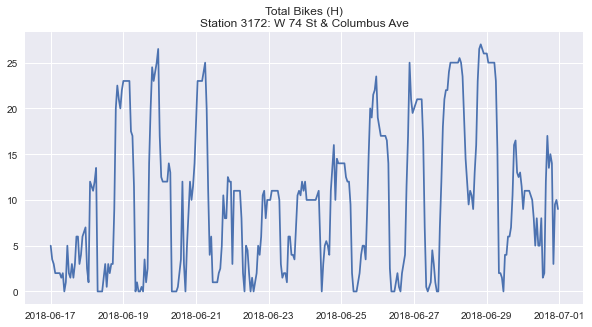

In [4]:
station_3172.plot_avail_bikes(time_interval=('2018-06-17','2018-06-30'))

You can see the typical weekly and daily seasonailty found in the Exploratory data analysis in this plot. On weekdays during the morning the morning there are many bikes taken from the station and then they are returned in the evening. Traffic on weekends is slower and Tuesdays, Wednesday and Thursdays are the most active days.

Using seasonal decomposition to be more isolate about this trend:`

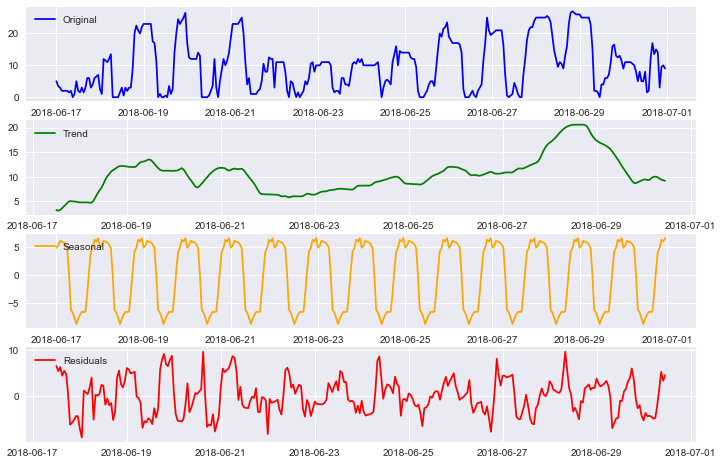

In [5]:
station_3172.availbike_decompose(time_interval=('2018-06-17','2018-06-30'))

The trend line somewhat shows the weekly seasonality, but doesn't capture it completely. The last weekend in June is also Pride weekend, which would be causing some of the irregularies in the daily and weekly seasonality on those days.

For modeling purposes, we'll get the time series itself from the station class:

In [6]:
train_ts = station_3172.avail_bikes_ts(time_interval=('2018-06-17','2018-06-30'))
test_ts = station_3172.avail_bikes_ts(time_interval=('2018-07-03 15:00','2018-07-14')).interpolate()

## Dummy Model

To get a baseline model we'll create a dummy model that predicts a constant value for all future timesteps. To do so, we'll use 0 AR terms and 0 MA terms to find the future value.

In [7]:
arima = ARIMA(train_ts, order=(0,0,0),enforce_invertibility=False,enforce_stationarity=False)
results = arima.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            avail_bikes   No. Observations:                  336
Model:                          ARIMA   Log Likelihood               -1172.114
Date:                Sun, 03 Jan 2021   AIC                           2348.227
Time:                        17:51:10   BIC                           2355.855
Sample:                    06-17-2018   HQIC                          2351.268
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.1416      0.494     20.523      0.000       9.173      11.110
sigma2        64.0594      7.611      8.417      0.000      49.143      78.976
===================================================================================
Ljung-Box (Q):                     2053.37   Jarque-Bera (JB):                24.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.48
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Our baseline AIC value is 2348.227 which we will use to compare furture SARIMA models. The model diagnostic plots below show that our model is performing poorly because of the high correlation still present in the correlogram and our residuals are not normally distributed.

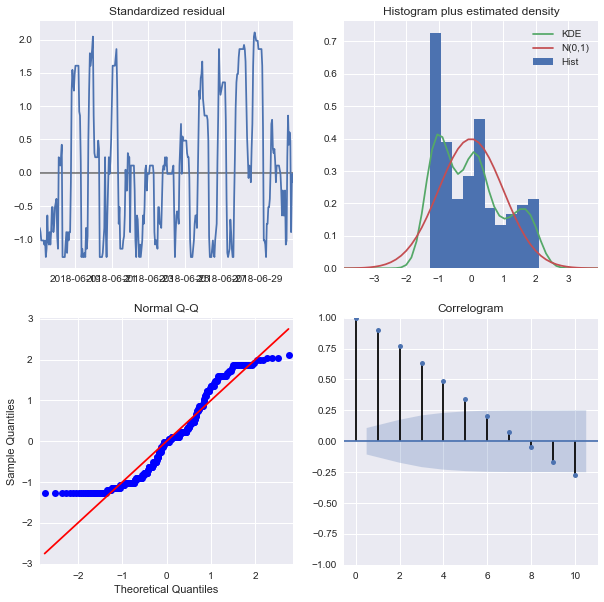

In [8]:
results.plot_diagnostics(figsize = (10,10));



#### Plotting the Dummy model

Using the dummy modelt to predict two weeks into the future and calculate the rmse on the future as the test set. Note the missing values. Our test will begin after the gap.

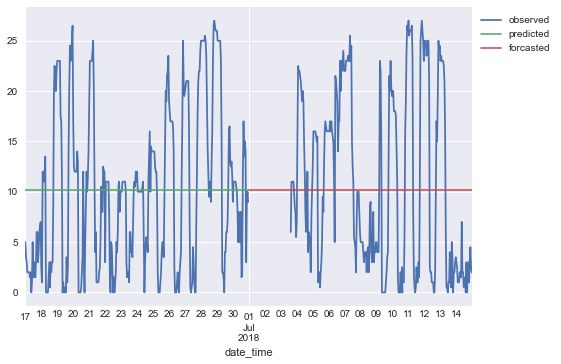

In [9]:
#get predictions

pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=True,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=24*14)
for_conf = forcast.conf_int()

ax = station_3172.avail_bikes_ts()['2018-06-17':'2018-07-14'].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)


plt.legend(bbox_to_anchor=(1,1), loc="upper left");

While using this constant value yeilds a decent RMSE and MAE scores on the train and test sets. This makes sense because there the capacity of the bike station does not change, so a mean value should actually be a decent predictor. Future models that perform well should decrease the value of both of these metrics.

In [10]:
print('Train:')
rmse_mae(train_ts,pred.predicted_mean)

print('Test: ')
rmse_mae(test_ts,forcast.predicted_mean['2018-07-03 15:00':])

Train:
RMSE: 7.996735044113908
MAE:  6.668103163050874

Test: 
RMSE: 8.971522785081762
MAE:  8.056437798887124



The ACF and PACF plots of our train set indicate that adding seasonality and increasing both the AR terms and the MA terms may increase model performance.

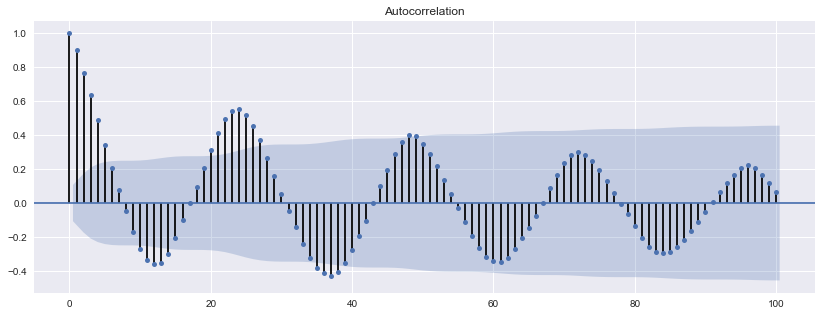

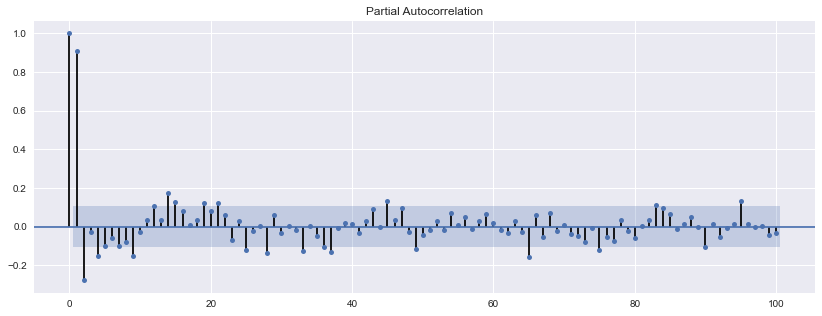

In [11]:
rcParams['figure.figsize'] = 14, 5
plot_acf(train_ts, lags=100);
plot_pacf(train_ts, lags=100);

## SARIMA Model

In order to capture the seasonality of the model, next we'll try SARIMA using a period of 24 to capture daily seasonality.

Setting up a grid search to find the best AR(p), Differincing (d) and MA(q) terms for both the trend and seasonality:

In [ ]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

np.random.seed(7)


#Generate combinations of the number of AR(p), MA(q), and Differencing (d) terms
p = d = q = range(0,3)
pdq = list(itertools.product(p,d,q))

#Generate combinations of seasonal AR(p), MA(q), and Differencing (d) terms
pdqs = [(x[0], x[1], x[2], 24) for x in pdq] 
count = 1

##grid search parameters using generated list of combinations
models=[]
for comb in pdq:
    for combs in pdqs:
        try:
            #try model
            arima = SARIMAX(ts, order=comb, seasonal_order=combs,
                          enforce_invertibility=False,enforce_stationarity=False)
            model = arima.fit()
            arima.fit()
            
            #append results to list
            models.append([comb,combs,model.aic])
            count += 1
        except:
            continue #skip order combination if error

#create data frame of model performance from list and sort by best AIC values
models_df = pd.DataFrame(models, columns=['pdq', 'pdqs', 'aic'])
models_df.sort_values('aic').head(20)


/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/o

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,pdq,pdqs,aic
386,"(1, 1, 2)","(0, 2, 2, 24)",1279.498264
305,"(1, 0, 2)","(0, 2, 2, 24)",1279.725411
278,"(1, 0, 1)","(0, 2, 2, 24)",1279.793646
629,"(2, 1, 2)","(0, 2, 2, 24)",1281.054609
548,"(2, 0, 2)","(0, 2, 2, 24)",1281.172763
521,"(2, 0, 1)","(0, 2, 2, 24)",1281.755760
287,"(1, 0, 1)","(1, 2, 2, 24)",1281.793625
467,"(1, 2, 2)","(0, 2, 2, 24)",1282.125600
710,"(2, 2, 2)","(0, 2, 2, 24)",1282.239199
557,"(2, 0, 2)","(1, 2, 2, 24)",1284.046100


In the sorted dataframe above we see that the model with the best AIC score brought the AIC score down significantly from the dummy model, indicating that this new seasonal model may perform better on the RMSE metric as well. This new model has has 1 AR, 1 Diff, and 2 MA terms and 2 seasonal diff, and 2 seasonal MA terms. However, only the first AR term and first MA term tern out to be statistically significant. This makes sense considering how close in value the AIC Scores are of the top 20 models, in other words those additional terms may not be helping the model significantly with p-values of less than 0.05

In [15]:
best_sarima = SARIMAX(train_ts, order=(1,1,2),seasonal_order=(0,2,2,24),
                    enforce_invertibility=False,enforce_stationarity=False)
results = best_sarima.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        avail_bikes   No. Observations:                  336
Model:             SARIMAX(1, 1, 2)x(0, 2, 2, 24)   Log Likelihood                -633.749
Date:                            Fri, 01 Jan 2021   AIC                           1279.498
Time:                                    23:39:07   BIC                           1300.281
Sample:                                06-17-2018   HQIC                          1287.876
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8093      0.076     10.718      0.000       0.661       0.957
ma.L1         -0.8083      0.102     -7.902      0.000      -1.009      -0.608
ma.L2         -0.1398      0.074     -1.884      0.060      -0.285       0.006
ma.S.L24      -1.8534     36.534     -0.051      0.960     -73.459      69.752
ma.S.L48       0.8542     31.173      0.027      0.978     -60.243      61.951
sigma2         8.5938    314.227      0.027      0.978    -607.280     624.467
===================================================================================
Ljung-Box (Q):                       24.04   Jarque-Bera (JB):                12.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.07
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model diagnostics look much better than the dummy model, the residuals are clost to normally distributed and the correlogram shows no statistically significant correlations. 

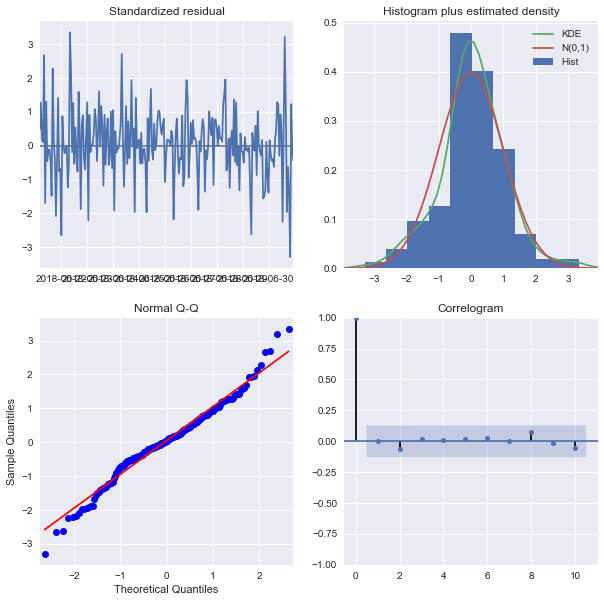

In [16]:
results.plot_diagnostics(figsize = (10,10));

#### Plotting SARIMA

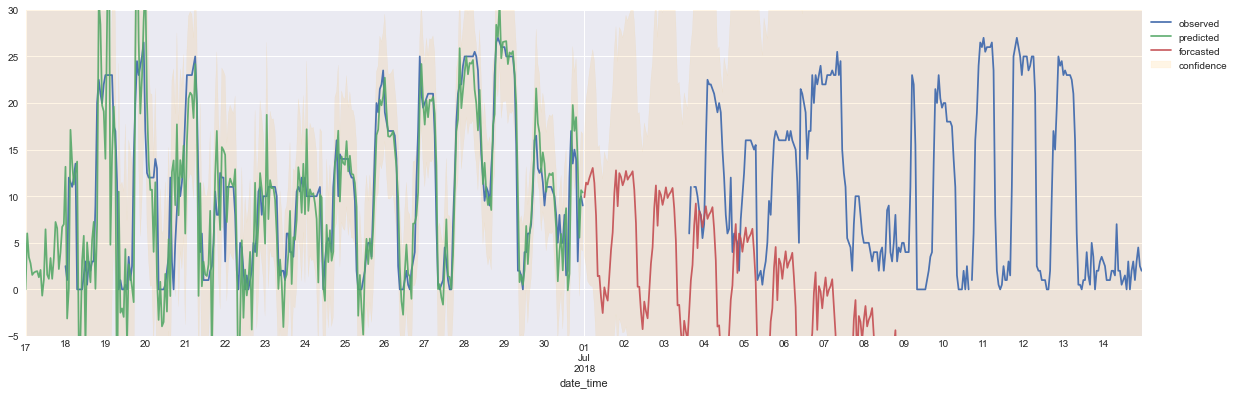

In [17]:
#get predictions
pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=False,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=336)
for_conf = forcast.conf_int()

rcParams['figure.figsize'] = 20, 6

#plot train and test
ax = station_3172.avail_bikes_ts()['2018-06-18':'2018-07-14'].plot(label='observed')

#plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:,1], color='orange',alpha=0.1, label='confidence')
ax.fill_between(for_conf.index,
               for_conf.iloc[:, 0],
               for_conf.iloc[:,1], color='orange',alpha=0.1)

#plot predictions
pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)

#focus window
ax.set_ylim(bottom=-5, top=30)

#move legend outside of plot
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

Based on this plot, this model seems to be extremely overfit and identified a non-existent downward trend. We can see the overfitting in the model's close capturing of the train data (both in confidence and in predicted value), but complete miss of the test set. This overfitting is also shown by the decreased the RMSE and the MAE on the train set from the dummy model, but increased on the test set.:

In [18]:
print('Train:')
rmse_mae(train_ts,pred.predicted_mean)

print('Test: ')
rmse_mae(test_ts,forcast.predicted_mean['2018-07-03 15:00':])

Train:
RMSE: 4.966456395968072
MAE:  3.367541757945296

Test: 
RMSE: 28.526738041576774
MAE:  25.44658195568028



### SARIMA removing some differencing

Let's try the SARIMA again but removing some of the differencing due to remove the downward trend:

In [19]:
best_sarima = SARIMAX(train_ts, order=(1,0,1),seasonal_order=(0,2,2,24),
                    enforce_invertibility=False,enforce_stationarity=False)
results = best_sarima.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             avail_bikes   No. Observations:                  336
Model:             SARIMAX(1, 0, 1)x(0, 2, [1, 2], 24)   Log Likelihood                -634.897
Date:                                 Fri, 01 Jan 2021   AIC                           1279.794
Time:                                         23:39:25   BIC                           1297.155
Sample:                                     06-17-2018   HQIC                          1286.791
                                          - 06-30-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8455      0.040     21.299      0.000       0.768       0.923
ma.L1          0.1351      0.071      1.894      0.058      -0.005       0.275
ma.S.L24      -1.8646     41.917     -0.044      0.965     -84.021      80.292
ma.S.L48       0.8653     36.234      0.024      0.981     -70.151      71.882
sigma2         8.2538    346.225      0.024      0.981    -670.335     686.843
===================================================================================
Ljung-Box (Q):                       22.84   Jarque-Bera (JB):                11.47
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -0.19
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This model has a very similar AIC score to the last and the diagnostics are also similar:

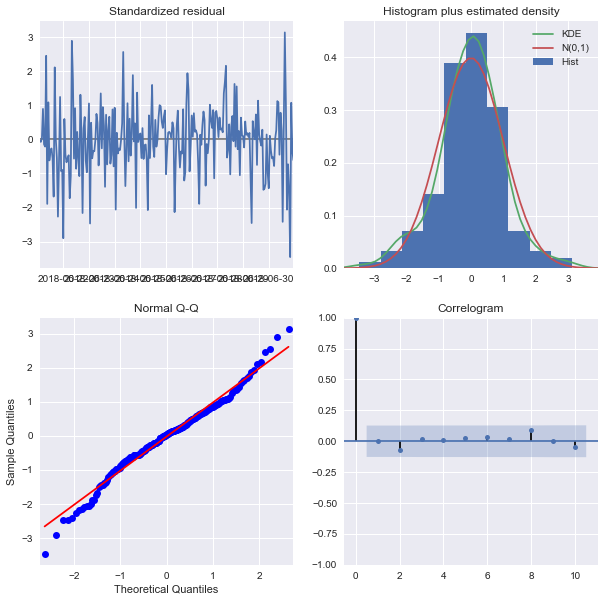

In [20]:
results.plot_diagnostics(figsize = (10,10));

#### Plotting new SARIMA

When we plot it we see a much better capture of the flat trend, although this model seems to pick up on a not present multiplicative seasonality and doesn't capture the weekly seasonality. In addition, the condifence on the test set captures a daily cycle, but has a wide range of values if could exist in.

/Users/mitchellkrieger/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/statespace/kalman_filter.py:2095: RuntimeWarning: invalid value encountered in multiply
  endog = np.empty((nforecast, self.k_endog)) * np.nan


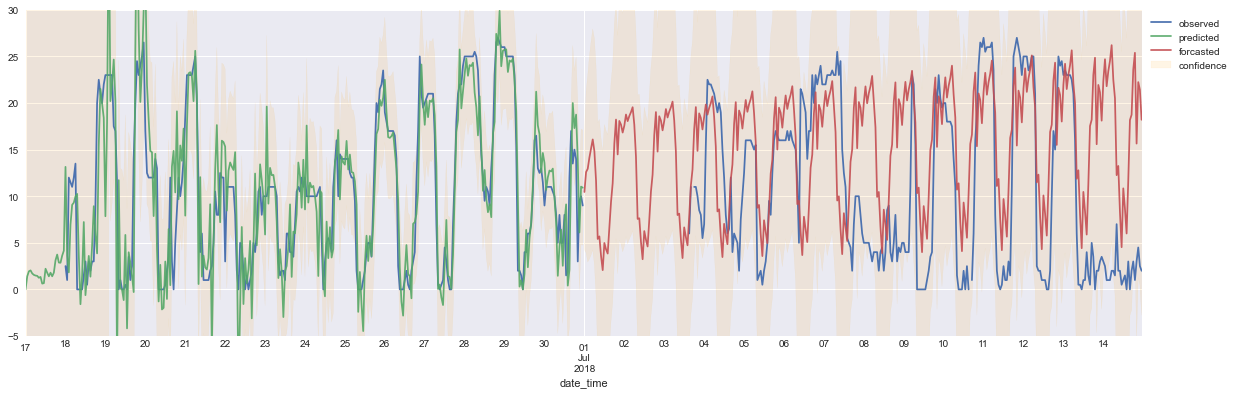

In [21]:
#get predictions
pred = results.get_prediction(start=pd.to_datetime('2018-06-17'),dynamic=False,full_results=True)
pred_conf = pred.conf_int()

forcast = results.get_forecast(steps=336)
for_conf = forcast.conf_int()

rcParams['figure.figsize'] = 20, 6

#plot train and test
ax = station_3172.avail_bikes_ts()['2018-06-18':'2018-07-14'].plot(label='observed')

#plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:, 0],
               pred_conf.iloc[:,1], color='orange',alpha=0.1, label='confidence')
ax.fill_between(for_conf.index,
               for_conf.iloc[:, 0],
               for_conf.iloc[:,1], color='orange',alpha=0.1)

#plot predictions
pred.predicted_mean.plot(ax=ax, label='predicted',alpha=0.9)
forcast.predicted_mean.plot(ax=ax, label='forcasted', alpha=0.9)

#focus window
ax.set_ylim(bottom=-5, top=30)

#move legend outside of plot
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

In [22]:
print('Train:')
rmse_mae(train_ts,pred.predicted_mean)

print('Test: ')
rmse_mae(test_ts,forcast.predicted_mean['2018-07-03 15:00':])

Train:
RMSE: 4.641044733943594
MAE:  3.1963864320095574

Test: 
RMSE: 9.712942916097616
MAE:  7.772506436962449



The train metrics perform similarly to the first SARIMA. Interestingly, the test RMSE performs a little worse where as the test MAE performs a little better. In addition, still the model does not capture weekly seasonality at all, we'll attempt some other kinds of models to try to capture this behavior:

## Recurring Neural Network (RNN) using Long Short Term Memory (LSTM)

Using the DarTS package, we'll build a basic RNN network using LSTM.

In [12]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.metrics import mape, rmse, mae

First, we need to prep the data for DarTS and the RNN by creating `TimeSeries` objects and scaling them:

In [13]:
#create Time Series object

ts = TimeSeries.from_dataframe(station_mat.interpolate().reset_index(),'date_time',['3172'])

#create train, validadtion and test sets using two week intervals without missing values
train = ts.slice(np.datetime64('2018-06-17'),np.datetime64('2018-06-30'))
valid = ts.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))
test = ts.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22'))

#rescale for modeling

scaler = Scaler()
train_scl = scaler.fit_transform(train)
valid_scl = scaler.transform(valid)
test_scl = scaler.transform(test)
ts_scl = scaler.transform(ts)

Running the RNN Model with some hyper parameters assigned through experimentation. Best Results shown here:

In [14]:
#model architecture
lstm = RNNModel(
    model='LSTM',
    output_length=1, # number of output time-steps to predict
    hidden_size=25, # Number of features in last hidden state
    n_rnn_layers=3, # Number of stacked rnn layers.
    input_length=24*7, # Number of previous time stamps taken into account.
    dropout=0.4,
    batch_size=24,
    n_epochs=30,
    optimizer_kwargs={'lr': 1e-3}, #Adam optimizer
    log_tensorboard=True,
    random_state=1
)

lstm.fit(training_series=train_scl, 
         val_training_series=valid_scl, 
         verbose=True)

Training loss: 0.1893, validation loss: nan


### Plotting RNN/LSTM
Plotting the model over the validation and test series:

In [15]:
#get predictions
forecast = scaler.inverse_transform(lstm.predict(n=24*85))

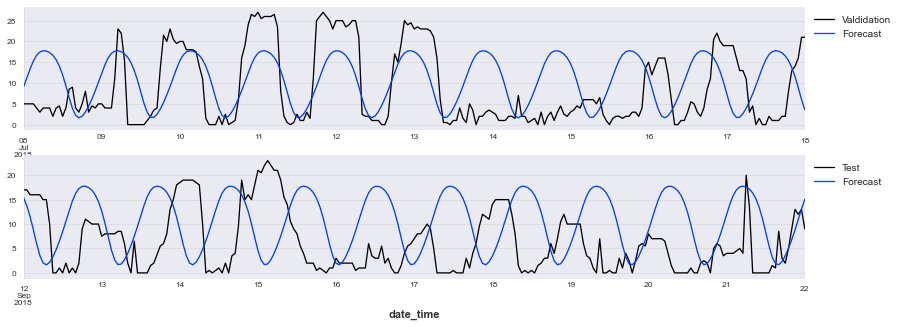

In [16]:
#validataion plot
fig, ax = plt.subplots(ncols=1,nrows=2)
valid.plot(ax=ax[0])
forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18')).plot(ax=ax[0])
ax[0].legend(['Valdidation','Forecast'],bbox_to_anchor=(1,1), loc="upper left");

#test plot
test.plot(ax=ax[1])
forecast.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22')).plot(ax=ax[1])
ax[1].legend(['Test','Forecast'],bbox_to_anchor=(1,1), loc="upper left");

The model does similar to SARIMA, in picking up on the daily season but not the weekly. However, when extending the model into september, the period of the daily seasonality seems to be a little off. This is further evidenced by the RMSE and MAE:

In [17]:
print('Validation: ')
print('RMSE: ',rmse(valid,forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))))
print('MAE: ',mae(valid,forecast.slice(np.datetime64('2018-07-08'),np.datetime64('2018-07-18'))))

print('Test: ')
print('RMSE: ',rmse(test,forecast.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22'))))
print('MAE: ',mae(test,forecast.slice(np.datetime64('2018-09-12'),np.datetime64('2018-09-22'))))

Validation: 
RMSE:  9.408965258636194
MAE:  8.018377381241669
Test: 
RMSE:  10.438916423792012
MAE:  8.796859608646251


This model's metrics also perform similar to SARIMA model on the validation set (which was the test set for SARIMA). The basic LSTM arichtecture may be not sophisticated enough to capture what the weekly trends and some of nuances of the time series. 

### More Sophisticated  Neural Network model using CNN-LSTM 

Switching from DarTS to Tensorflow to run more sophisticated models that combines LSTM and Convolutional layers:

In [18]:
#code adapted from Machine Learning Mastery

n_seq = 4 # subsequences
n_steps = 12 # steps per subsequence 
n_filters = 64 # output filters from convolution
n_kernel = 3 # convolutional window size
n_nodes = 100 #nodes in LSTM & dense layers
n_epochs = 50 #number of epochs to run
n_batch = 100 #batch size
n_input = n_seq * n_steps
# prepare data
train_data = series_to_supervised(train_ts.values, n_in=n_input)
train_x, train_y = train_data[:, :-1], train_data[:, -1]
train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))

val_data = series_to_supervised(test_ts.values, n_in=n_input)
val_x, val_y = val_data[:, :-1], val_data[:, -1]
val_x = val_x.reshape((val_x.shape[0], n_seq, n_steps, 1))

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(None,n_steps,1))))
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
#model.add(Dropout(.5))
model.add(LSTM(n_nodes, activation='relu'))
#model.add(Dropout(.5))
model.add(Dense(n_nodes, activation='relu'))
#model.add(Dropout(.5))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit
model.fit(train_x, train_y, validation_data=(val_x,val_y),epochs=n_epochs, batch_size=n_batch, verbose=1)
model.summary()



Epoch 1/50
3/3 [==============================] - 0s 86ms/step - loss: 173.4167 - val_loss: 153.9345
Epoch 2/50
3/3 [==============================] - 0s 15ms/step - loss: 106.9178 - val_loss: 81.6553
Epoch 3/50
3/3 [==============================] - 0s 16ms/step - loss: 70.1874 - val_loss: 69.5425
Epoch 4/50
3/3 [==============================] - 0s 16ms/step - loss: 50.6797 - val_loss: 58.8303
Epoch 5/50
3/3 [==============================] - 0s 21ms/step - loss: 44.0426 - val_loss: 44.7403
Epoch 6/50
3/3 [==============================] - 0s 25ms/step - loss: 29.9704 - val_loss: 47.3993
Epoch 7/50
3/3 [==============================] - 0s 23ms/step - loss: 29.1648 - val_loss: 37.9001
Epoch 8/50
3/3 [==============================] - 0s 17ms/step - loss: 23.8385 - val_loss: 35.9828
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 21.8150 - val_loss: 34.4288
Epoch 10/50
3/3 [==============================] - 0s 19ms/step - loss: 20.6637 - val_loss: 31.1206
Epoch 

Without the addition of the 3 dropout layers abover the model nearly identically matches this model's test and validation and also performs really decently on test sets in September and October based on their plots.

Text(0, 0.5, 'Oct (Test 2)')

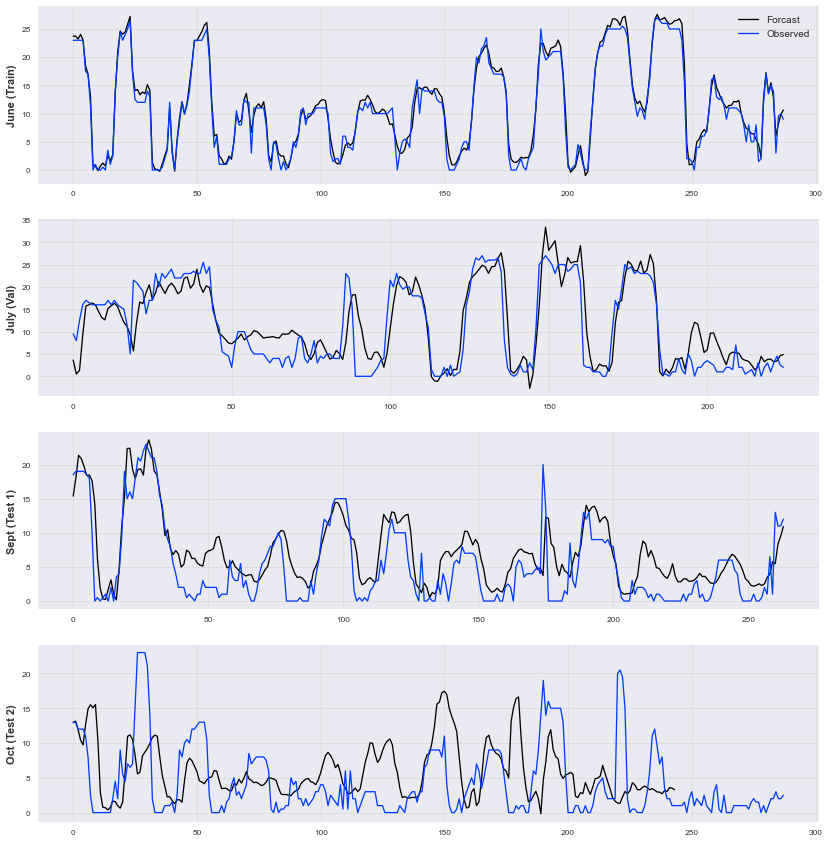

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=4)

fig.set_figheight(15)

#plot train + train predictions
y_train_pred = model.predict(train_x)
ax[0].plot(y_train_pred,label='Forcast')
ax[0].plot(train_ts.values[n_seq*n_steps:],label='Observed')
ax[0].set_ylabel('June (Train)')
ax[0].legend()


#plot validation + validation predictions
y_val_pred = model.predict(val_x)
ax[1].plot(y_val_pred)
ax[1].plot(test_ts.values[n_seq*n_steps:])
ax[1].set_ylabel('July (Val)')

#prep test 1 data
test1_ts = station_3172.avail_bikes_ts(time_interval=('2018-09-12','2018-09-24')).interpolate()

test_data = series_to_supervised(test1_ts.values, n_in=n_input)
test_x, test_y = test_data[:, :-1], test_data[:, -1]
test_x = test_x.reshape((test_x.shape[0], n_seq, n_steps, 1))


#plot test1 + test 1 predictions
y_test_pred = model.predict(test_x)

ax[2].plot(y_test_pred)
ax[2].plot(test1_ts.values[n_seq*n_steps:])
ax[2].set_ylabel('Sept (Test 1)')

#prep test 2 data
test2_ts = station_3172.avail_bikes_ts(time_interval=('2018-10-01','2018-10-14')).interpolate()


test2_data = series_to_supervised(test2_ts.values, n_in=n_input)
test2_x, test2_y = test2_data[:, :-1], test_data[:, -1]
test2_x = test2_x.reshape((test2_x.shape[0], n_seq, n_steps, 1))

#plot test 2 + test 2 predictions
y_test_pred = model.predict(test2_x)

ax[3].plot(y_test_pred)
ax[3].plot(test2_ts.values[n_seq*n_steps:])
ax[3].set_ylabel('Oct (Test 2)')

#### Walk-Forward Validation 

Using walk-forward validation, this model regularly performs well in comparison to SARIMA's test metrics.

> RMSE: 5.306 	 MAE: 3.867
> RMSE: 4.982 	 MAE: 3.693
> RMSE: 4.573 	 MAE: 3.356
> RMSE: 4.793 	 MAE: 3.537
> RMSE: 4.783 	 MAE: 3.658
> RMSE: 5.202 	 MAE: 4.006
> RMSE: 4.77 	 MAE: 3.57
> RMSE: 5.114 	 MAE: 3.787
> RMSE: 5.186 	 MAE: 3.838
> RMSE: 4.776 	 MAE: 3.494
> RMSE: 4.713 	 MAE: 3.499
> RMSE: 4.756 	 MAE: 3.56
> RMSE: 4.7 	 MAE: 3.465
> RMSE: 4.735 	 MAE: 3.499
> RMSE: 5.308 	 MAE: 3.98
> RMSE: 5.059 	 MAE: 3.61
> RMSE: 5.396 	 MAE: 4.052
> RMSE: 4.71 	 MAE: 3.502
> RMSE: 4.742 	 MAE: 3.547
> RMSE: 4.421 	 MAE: 3.24
> RMSE: 5.04 	 MAE: 3.789
> RMSE: 5.16 	 MAE: 3.88
> RMSE: 5.005 	 MAE: 3.74
> RMSE: 4.787 	 MAE: 3.598
> RMSE: 4.886 	 MAE: 3.668
> RMSE: 4.993 	 MAE: 3.793
> RMSE: 4.888 	 MAE: 3.545
> RMSE: 5.013 	 MAE: 3.685
> RMSE: 4.447 	 MAE: 3.196
> RMSE: 5.183 	 MAE: 3.938
cnn-lstm: 4.914 RMSE (+/- 0.246)
cnn-lstm: 3.653 MAE (+/- 0.210)


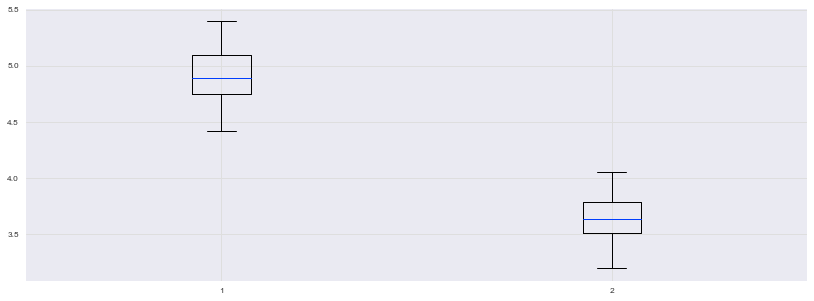

In [20]:
# data split
n_test = 12
# hyperparameters
config = [3, 12, 64, 3, 100, 200, 100] #n_seq, n_steps, n_filters, n_kernel, n_nodes,n_epochs, n_batch
# Walk-Forward Validation
scores = repeat_evaluate(train_ts.values, test_ts.values, config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)

Based on these metrics the CNN LSTM model is on average off 4-5 bikes. Even though this model accurately predicts the number of bikes at this station much better than SARIMA, it doesn't capture either the daily, weekly or yearly seasonality generally, which is what we will need to be able to classify stations as pools, drains or balanced.

## Facebook Prophet

Facebook Prophet may be a good alternative to CNN-LSTM because its construction includes fourier series that captures seasonality extremely well and handels gaps missing data much better than SARIMA or CNN-LSTM. 

Prophet requires time series to be in a dataframe with a `ds` colum for the time step and a `y` column for the target variable.

Note: This section was run in google colab

In [42]:
from fbprophet import Prophet
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [44]:
from station import *

In [45]:
station_3172 = Station(3172)

In [46]:
#create fbprophet readable dataframes
train = pd.DataFrame(station_3172.avail_bikes_ts(time_interval=('2018-06-17','2018-06-30')))
train = train.reset_index().rename(columns={'date_time':'ds','avail_bikes':'y'})

test = pd.DataFrame(station_3172.avail_bikes_ts(time_interval=('2018-07-08','2018-07-18')))
test = test.reset_index().rename(columns={'date_time':'ds','avail_bikes':'y'})

For the first Facebook Prophet model, we'll allow Prophet to predict the number of terms in the fourier series for each seasonality. Because we are currently working only with two weeks data, we'll disable yearly seasonality.

In [47]:
#instantiate and fit model to train set
m = Prophet(growth = 'flat',daily_seasonality=True, weekly_seasonality=True)
m.fit(train)

#predict future and display prediction and confidence levels
future = m.make_future_dataframe(periods = 18*24, freq='H')
forcast = m.predict(future)
forcast[['ds','yhat','yhat_lower','yhat_upper']].head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
0,2018-06-17 00:00:00,12.914824,6.034103,19.263014
1,2018-06-17 01:00:00,12.377725,5.642751,18.671328
2,2018-06-17 02:00:00,12.222265,5.720095,18.571442
3,2018-06-17 03:00:00,12.534084,6.596814,19.132854
4,2018-06-17 04:00:00,12.831202,6.295178,19.215262


#### Plotting Default Prophet

To see how the model performs, let's first look at the plot.

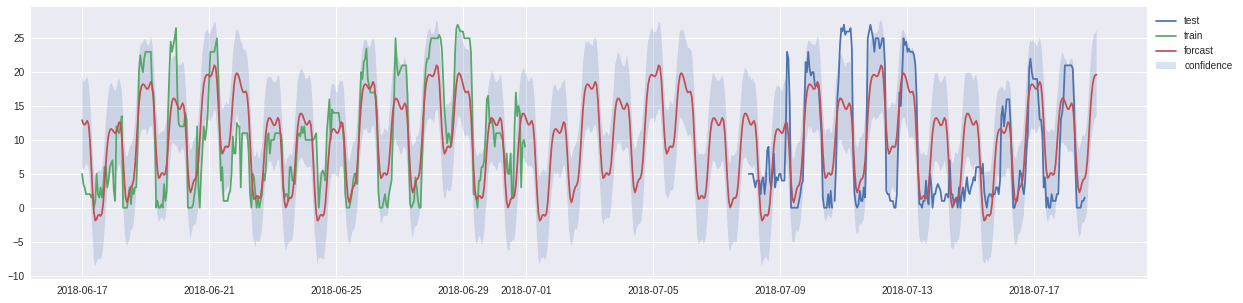

In [48]:
# make timestamp index for easy plotting of time series
train_ts = train.set_index('ds')
forcast_ts = forcast.set_index('ds')
test_ts = test.set_index('ds')

#create plot
plt.style.use('seaborn')
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.plot(test_ts,label='test')
ax.plot(train_ts,label='train')
ax.plot(forcast_ts.yhat,label='forcast')
ax.fill_between(forcast_ts.index,forcast_ts.yhat_lower,forcast_ts.yhat_upper,alpha=0.2,label='confidence')
plt.title('Facebook Prophet',fontdict={'fontsize'=20})
plt.legend(bbox_to_anchor=(1,1), loc="upper left");

Visually, this is our best performing model to so far. It captures both the daily and weekly seasonalities and most points fall within the confidence interval. The RMSE and the MAE values of both the train and test sets are not as good as CNN-LSTM, however, this model much captures general seasonality much better which will be much more useful in the identification of drains, pools, and balanced stations than just accurately predicting bike availability at stations alone.

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
train_rmse = mean_squared_error(y_true=train_ts, y_pred=forcast_ts.yhat[:'2018-06-30'],squared=False)
test_rmse = mean_squared_error(y_true=test_ts.interpolate(),y_pred=forcast_ts.yhat['2018-07-08':],squared=False)

train_mae = mean_absolute_error(y_true=train_ts, y_pred=forcast_ts.yhat[:'2018-06-30'])
test_mae = mean_absolute_error(y_true=test_ts.interpolate(),y_pred=forcast_ts.yhat['2018-07-08':])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 5.0408323291500325
Train MAE:  4.122646416308141

Test RMSE: 6.300469732302041
Test MAE:  5.150849898391775


Checking further out in the furture we see that his model still closely models the actual time series even in September:

(736949.0, 736965.0, -5.0, 30.0)

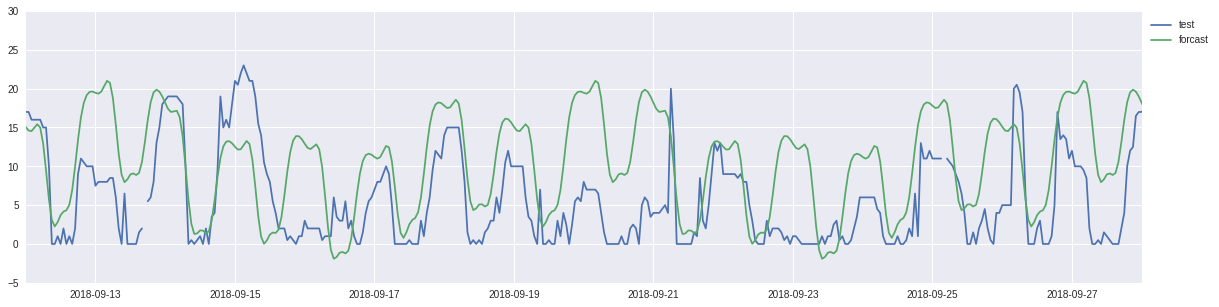

In [50]:
#extend future dataframe further
future2 = m.make_future_dataframe(periods=24*180,freq='H')
forcast2 = m.predict(future2)

#set as pandas time series 
forcast2_ts = forcast2.set_index('ds')
test2_ts = station_3172.avail_bikes_ts(time_interval=('2018-09-12','2018-09-28'))

#plot
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(20)
ax.plot(test2_ts,label='test')
ax.plot(forcast2_ts.yhat,label='forcast')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.axis([np.datetime64('2018-09-12'),np.datetime64('2018-09-28'),-5,30])

Using This September interval as our test, it gives us an RMSE and MAE scores slightly better than the dummy model but this model captures seasonality. This additional error may be do to exogonous variables such as colder weather in septermber and or rain.

In [51]:
train_rmse = mean_squared_error(y_true=train_ts, y_pred=forcast_ts.yhat[:'2018-06-30'],squared=False)
test_rmse = mean_squared_error(y_true=test2_ts.interpolate(),y_pred=forcast2_ts.yhat['2018-09-12':'2018-09-28'],squared=False)

train_mae = mean_absolute_error(y_true=train_ts, y_pred=forcast_ts.yhat[:'2018-06-30'])
test_mae = mean_absolute_error(y_true=test2_ts.interpolate(),y_pred=forcast2_ts.yhat['2018-09-12':'2018-09-28'])

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

print(f'Test RMSE: {test_rmse}')
print(f'Test MAE:  {test_mae}')

Train RMSE: 5.0408323291500325
Train MAE:  4.122646416308141

Test RMSE: 7.488500094975468
Test MAE:  6.252384093510605


### Model Decomposition
Looking at the constuction of this model, we find 3 fourier terms for the daily seasonality and 4 for the weekly seasonality. The weekly seasonality reflects what we learned from the EDA, that Tuesday/Wednesdays.Thursdays are the most heavy use of the citibike system, and in the daily seasonality it reflects the morning and evening commutes. The Daily seasonality will be important for clustering later.

OrderedDict([('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 10.0})])

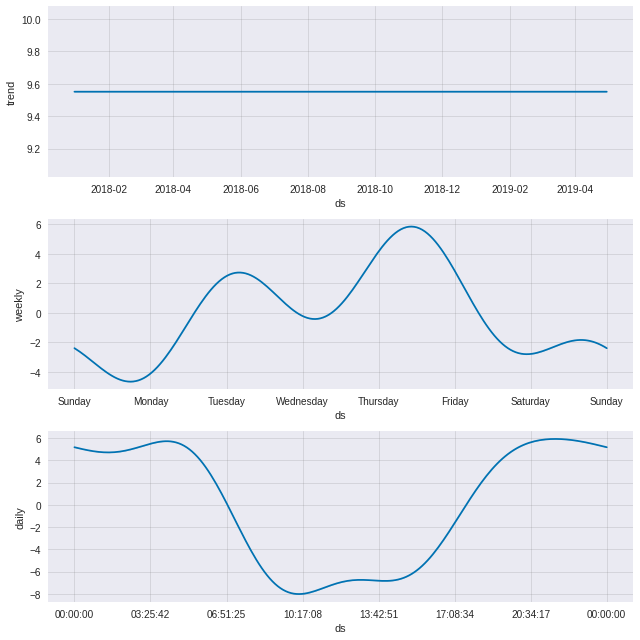

In [75]:
m.plot_components(forcast);
plt.savefig('seasonality.png')
m.seasonalities

### Year Model

Facebook Prophet can easily with missing values in a time series, let's see if extending the data fed into the model to all of 2018:

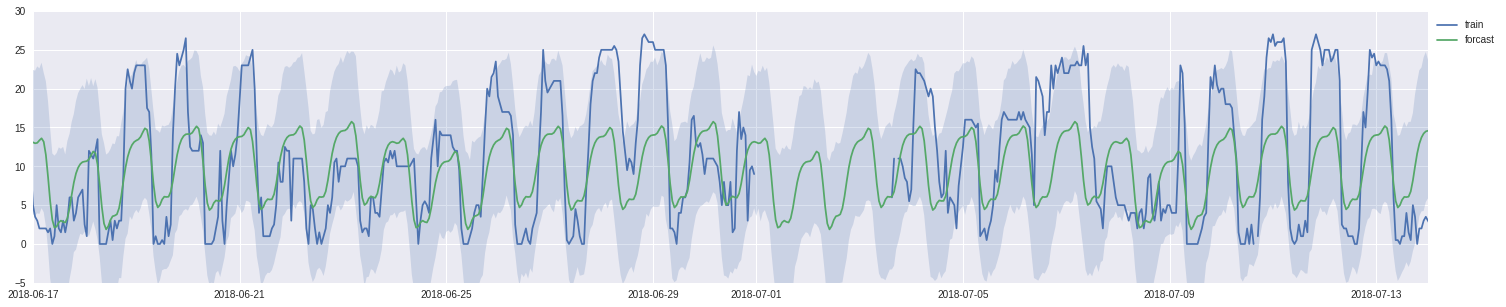

In [53]:
#prep ts for facebook prophet
train_year = pd.DataFrame(station_3172.avail_bikes_ts())
train_year = train_year.reset_index().rename(columns={'date_time':'ds','avail_bikes':'y'})

#instantiate and fit model
year_model = Prophet(growth= 'flat',yearly_seasonality=False,weekly_seasonality=True,daily_seasonality=True)
year_model.fit(train_year)

#predict future
future = year_model.make_future_dataframe(periods = 24*119,freq='H')
forcast = year_model.predict(future)

#create pandas timeseries for plotting
forcast_year_ts = forcast.set_index('ds')
true_year_ts = train_year.set_index('ds')

#plot
fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(25)
ax.plot(true_year_ts,label='train')
ax.plot(forcast_year_ts.yhat,label='forcast')
ax.fill_between(forcast_year_ts.index,forcast_year_ts.yhat_lower,forcast_year_ts.yhat_upper,alpha=0.2)
plt.axis([np.datetime64('2018-06-17'),np.datetime64('2018-07-14'),-5,30])

plt.legend(bbox_to_anchor=(1,1), loc="upper left");

While the confidence intervals still cover much of acutal available bikes, the weekly and daily seasonality has been dampened. This is perhaps due to differing levels of use throughout the year, and missing data in August for this particular station (3172). However, the RMSE values and the MAE values are slightly better than our dummy baseline model:

In [54]:
train_rmse = mean_squared_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],
                   squared=False)

train_mae = mean_absolute_error(y_true=true_year_ts.y.interpolate(),
                   y_pred=forcast_year_ts.yhat[:'2018-12-31'],)

print(f'Train RMSE: {train_rmse}')
print(f'Train MAE:  {train_mae}\n')

Train RMSE: 7.461124727764859
Train MAE:  6.210672939928366



#### Decomposition

The decomposition shows us that despite the same number of fourier terms and the same scale, the weekly seasonality is incorrect, picking the highest amount of useage on Saturdays. However, the daily is still accurate.

OrderedDict([('weekly',
              {'condition_name': None,
               'fourier_order': 3,
               'mode': 'additive',
               'period': 7,
               'prior_scale': 10.0}),
             ('daily',
              {'condition_name': None,
               'fourier_order': 4,
               'mode': 'additive',
               'period': 1,
               'prior_scale': 10.0})])

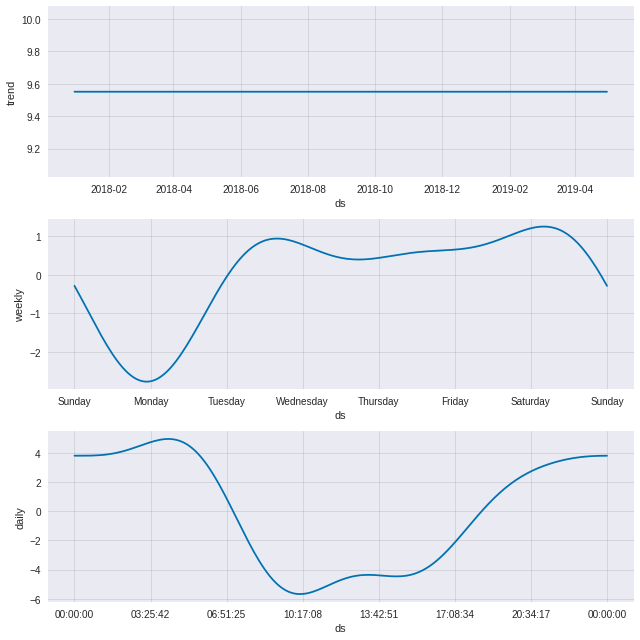

In [55]:
year_model.plot_components(forcast);
m.seasonalities

#### Cross Validation and grid search

To see if we make our results better, we'll cross validate and grid search models changing the seasonality and changepoint scales:

In [56]:
from fbprophet.diagnostics import performance_metrics, cross_validation
import itertools

#parameters to search over
params = {
    'change_point_prior_scale':[.001,.01,.1,.5,1],
    'seasonality_prior_scale':[.01,.1,1,5,10]
}

#generates combinations of parameters
combs = [dict(zip(params.keys(),value)) for value in itertools.product(*params.values())]
print('Number of searches: ',len(combs))

#cross validation by training for 3 months then predicting every month after.
cv = cross_validation(year_model, initial = '2160 hours', period='2160 hours',horizon='720 hours',
                      parallel='processes')

#run performance metrics on cross validation
performance = performance_metrics(cv)

#sort cv models by best RMSE and display top 10
performance.sort_values('rmse',ascending=True).head(10)

INFO:fbprophet:Making 3 forecasts with cutoffs between 2018-06-04 23:00:00 and 2018-12-01 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fbf5b421eb8>


Number of searches:  25


INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
444,22 days 19:00:00,26.130804,5.111830,4.339282,0.922849,0.947977
443,22 days 18:00:00,26.281671,5.126565,4.352254,0.930747,0.947977
445,22 days 20:00:00,26.857461,5.182418,4.405097,0.922849,0.942197
442,22 days 17:00:00,26.875790,5.184186,4.401120,0.934232,0.947977
441,22 days 16:00:00,27.210917,5.216408,4.431108,0.930747,0.947977
440,22 days 15:00:00,27.803776,5.272929,4.467910,0.922849,0.947977
446,22 days 21:00:00,28.335955,5.323153,4.522017,0.922849,0.936416
439,22 days 14:00:00,28.700809,5.357314,4.519688,0.922378,0.947977
438,22 days 13:00:00,29.555828,5.436527,4.561067,0.915942,0.942197
447,22 days 22:00:00,29.972039,5.474673,4.630729,0.922378,0.930636


We were able to achieve similar train set RMSE and MAE scores for the yearly model than we were with the 2 week inital model. This may be because we picked a 2 weeks (22 days) interval for our first Prophet model which happened to also be the optimal horizon as seen by the minimum at around 23 in the graph below.

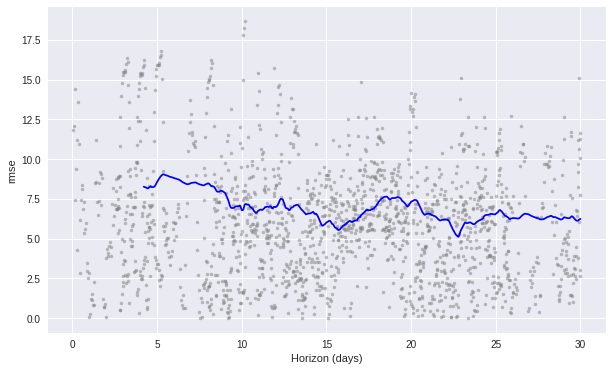

In [57]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv, metric='rmse')

### Apply the model to all years

Because we can train the model on an ideal 2 week set and get a somewhat similar RMSE/MAE values and clearly the facebook prophet model is our best model so far (based on both RMSE/MAE scores and seasonality), let's attempt to create Prophet models for all stations using the just the two week interval.

In [58]:
#create station matrix and remove stations installed late in 2018
year_2018 = pickle.load(open('/gdrive/MyDrive/Flatiron/Capstone/historical.pickle','rb'))
station_mat = year_2018.avail_bikes.swaplevel().unstack().resample('H').mean()
station_mat.columns = [str(col) for col in station_mat.columns]
station_drop = list(station_mat['2018-06-17':'2018-06-30'].isna().sum().sort_values(ascending=False).head(45).index)
station_drop.append('3259')
station_mat = station_mat.drop(columns=station_drop)

#create dataframes to store station forcasts and daily seasonalities of stations
system_forcast = pd.DataFrame()
system_daily = pd.DataFrame()
for col in station_mat.columns:
  #prep station time series for prophet
  station_ts = station_mat[col]['2018-06-17':'2018-06-30'].reset_index().rename(columns={'date_time':'ds',col:'y'})

  #create and fit prophet
  print(col)
  model = Prophet(growth='flat',weekly_seasonality=True,daily_seasonality=True);
  try:
    model.fit(station_ts);
  except:
    print('error at ',col)
    continue

  #predict future
  future = model.make_future_dataframe(periods = 180*24, freq='H')
  forecast = model.predict(future)

  #add to system dataframe
  forecast.rename(columns={'yhat':'yhat_'+col,'daily':'daily_'+col},inplace=True)
  system_forcast['yhat_'+col] = forecast['yhat_'+col]
  system_daily['daily_'+col] = forecast['daily_'+col]

  system_forcast.head()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


72


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


79


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


82


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


83


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


119


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


120


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


144


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


146


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


150


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


157


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


161


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


167


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


168


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


173


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


174


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


216


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


217


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


228


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


229


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


232


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


236


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


237


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


238


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


239


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


241


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


242


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


243


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


244


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


245


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


247


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


248


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


251


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


252


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


253


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


254


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


257


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


258


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


259


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


260


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


261


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


262


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


264


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


265


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


266


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


268


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


270


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


274


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


276


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


278


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


279


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


280


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


281


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


282


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


285


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


289


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


291


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


295


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


296


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


297


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


301


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


303


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


304


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


306


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


307


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


309


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


310


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


311


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


312


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


313


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


315


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


316


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


317


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


320


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


321


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


322


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


323


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


324


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


325


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


326


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


327


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


328


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


330


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


331


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


332


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


334


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


337


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


339


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


340


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


341


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


342


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


343


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


344


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


347


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


350


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


351


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


353


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


355


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


357


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


358


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


359


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


360


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


361


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


362


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


364


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


365


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


366


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


369


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


372


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


373


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


376


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


380


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


382


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


383


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


386


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


387


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


388


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


389


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


390


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


391


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


392


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


394


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


396


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


398


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


400


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


401


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


402


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


405


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


406


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


408


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


409


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


410


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


411


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


412


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


416


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


417


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


418


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


419


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


420


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


422


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


423


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


426


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


427


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


432


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


433


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


436


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


437


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


438


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


439


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


440


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


441


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


442


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


443


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


445


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


446


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


448


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


449


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


450


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


454


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


455


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


457


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


458


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


459


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


460


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


461


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


462


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


465


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


467


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


468


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


469


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


470


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


471


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


472


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


473


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


474


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


476


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


477


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


478


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


479


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


480


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


481


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


482


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


484


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


485


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


486


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


487


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


490


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


491


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


492


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


494


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


499


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


500


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


501


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


503


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


504


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


505


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


507


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


513


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


514


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


515


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


516


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


517


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


518


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


519


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


520


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


522


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


524


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


526


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


528


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


529


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


530


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


531


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


532


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


533


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


534


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


536


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


537


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


539


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


540


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


545


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


546


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2001


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2002


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2003


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2005


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2006


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2008


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2009


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2010


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2012


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2021


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2022


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2023


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3002


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3016


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3041


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3042


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3043


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3044


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3046


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3047


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3048


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3049


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3050


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3052


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3053


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3054


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3055


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3056


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3057


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3058


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3059


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3060


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3061


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3062


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3063


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3064


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3065


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3066


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3067


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3068


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3069


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3070


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3071


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3072


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3073


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3074


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3075


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3076


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3077


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3078


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3080


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3081


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3082


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3083


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3085


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3086


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3087


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3088


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3090


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3091


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3092


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3093


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3094


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3096


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3100


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3101


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3102


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3103


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3105


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3106


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3107


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3108


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3109


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3110


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3112


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3113


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3115


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3116


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3117


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3118


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3119


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3120


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3121


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3122


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3123


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3124


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3125


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3126


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3127


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3128


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3129


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3130


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3131


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3132


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3134


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3136


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3137


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3139


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3140


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3141


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3142


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3143


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3144


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3145


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3146


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3147


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3148


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3150


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3151


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3152


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3156


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3157


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3158


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3159


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3160


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3161


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3162


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3163


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3165


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3166


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3167


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3168


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3169


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3170


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3171


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3172


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3173


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3175


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3176


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3177


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3178


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3179


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3180


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3182


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3183


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3184


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3185


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3186


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3187


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3191


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3192


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3193


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3194


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3195


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3196


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3198


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3199


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3201


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3202


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3203


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3206


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3207


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3209


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3210


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3212


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3213


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3214


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3220


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3221


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3225


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3226


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3231


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3232


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3233


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3235


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3236


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3241


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3242


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3243


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3244


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3249


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3254


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3255


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3256


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3258


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3260


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3263


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3268


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3269


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3270


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3272


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3273


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3275


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3276


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3277


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3278


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3279


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3280


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3281


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3282


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3283


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3284


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3285


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3286


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3288


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3289


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3290


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3292


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3294


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3295


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3296


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3297


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3298


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3299


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3300


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3301


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3302


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3303


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3304


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3305


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3306


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3307


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3308


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3309


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3310


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3311


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3312


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3313


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3314


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3315


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3317


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3318


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3319


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3320


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3321


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3322


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3323


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3324


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3326


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3327


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3328


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3330


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3331


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3332


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3333


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3335


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3336


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3337


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3338


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3339


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3340


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3341


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3342


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3343


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3344


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3345


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3346


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3347


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3348


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3349


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3350


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3351


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3352


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3354


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3355


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3357


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3358


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3359


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3360


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3361


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3362


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3364


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3365


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3366


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3367


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3368


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3369


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3370


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3371


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3372


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3373


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3374


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3375


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3376


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3377


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3378


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3379


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3381


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3382


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3383


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3384


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3386


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3387


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3388


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3389


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3390


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3391


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3392


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3393


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3394


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3396


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3397


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3398


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3399


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3400


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3401


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3402


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3403


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3404


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3405


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3408


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3409


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3410


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3411


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3412


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3413


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3414


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3415


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3417


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3418


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3419


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3420


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3421


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3422


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3423


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3424


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3425


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3427


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3429


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3430


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3431


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3434


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3435


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3437


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3438


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3440


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3443


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3447


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3449


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3452


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3453


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3454


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3456


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3457


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3458


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3459


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3461


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3462


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3463


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3466


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3467


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3469


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3472


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3474


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3476


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3477


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3478


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3479


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3481


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3483


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3486


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3489


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3490


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3491


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3492


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3493


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3494


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3495


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3496


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3498


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3499


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3500


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3501


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3502


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3503


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3504


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3505


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3506


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3507


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3508


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3509


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3510


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3511


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3512


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3513


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3514


We'll use the resultant daily trends of these models to assess whether stations are pools, drains or balanced via clustering in the next notebook.

In [60]:
#assign datetime from original dataframe to rows
system_forcast['date_time'] = pd.to_datetime(forecast.ds) 
system_daily['date_time'] = pd.to_datetime(forecast.ds) 

In [61]:
#set date time as index
system_forcast = system_forcast.set_index('date_time')
system_daily = system_daily.set_index('date_time')

In [63]:
#saving daily seasonalities and system forcasts
pickle_out = open('/gdrive/MyDrive/Flatiron/Capstone/system_forcast.pickle','wb')
pickle.dump(system_forcast,pickle_out)
pickle_out.close()

pickle_out = open('/gdrive/MyDrive/Flatiron/Capstone/system_daily.pickle','wb')
pickle.dump(system_daily,pickle_out)
pickle_out.close()

The Facebook prophet model also has the ability to easily handle the entire year and malfunctioning stations (thus missing data), therefore it will be a convenient model to choose to cluster on. This particular model also demonstrates the seasonality of the system well when decomposed. As this sample station is a residential neighborhood, we see more bikes at the station in the evening and fewer bikes during the day. We can also see from the same Tuesday/Wednesday/Thursday spike in the weekly seasonality as we did in our EDA.

## Clustering

Analysis & Clustering continues in `03_clustering.ipynb`